In [168]:
# from Kaggle https://www.kaggle.com/msambare/fer2013

import matplotlib.pyplot as plt
import os
import tensorflow as tf

IMG_DIM = (48, 48)
CLASSES = os.listdir(os.path.join(os.curdir, 'train'))
N_CLASSES = len(CLASSES)

def load_images(directory, shuffle=False):
    X = []
    y = []
    
    for i, klass in enumerate(CLASSES):
        for _, _, filenames in os.walk(f'{directory}/{klass}'):
            images = [tf.io.decode_jpeg(tf.io.read_file(f'{directory}/{klass}/{fname}'), channels=3)
                      for fname in filenames]
            X.extend(images)
            y.extend([i] * len(images))
            
    idx = np.arange(len(X))

    if shuffle:
        rng = np.random.default_rng(42)
        rng.shuffle(idx)
        
    return np.array(X)[idx], np.array(y)[idx]

trainX, trainy = load_images('train')
testX, testy = load_images('test')

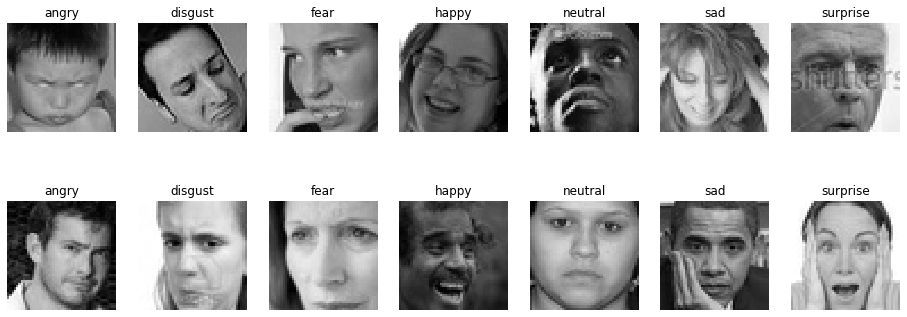

In [127]:
plt.figure(figsize=(16, 6))

for i in range(N_CLASSES):
    for j in range(2):
        plt.subplot(2, 7, i + 1 + j * 7)
        plt.imshow(trainX[trainy == i][j], cmap='binary_r', interpolation='nearest')
        plt.axis('off')
        plt.title(CLASSES[i])
    
plt.show()

In [128]:
from tensorflow.keras import callbacks, layers, models

In [150]:
def build_conv2d_model(n_convd_layers=1, n_dense_layers=1, n_neurons=50):
    model = models.Sequential([
        layers.InputLayer(input_shape=IMG_DIM + (3,)),
        layers.Rescaling(1./255)
    ])
    
    for i in range(n_convd_layers):
        model.add(layers.Conv2D(filters=32 * (i + 1), kernel_size=3, activation='relu'))
        model.add(layers.MaxPool2D(pool_size=2))
        
    model.add(layers.Flatten())
    
    for _ in range(n_dense_layers):
        model.add(layers.Dense(n_neurons, activation='relu'))
        
    model.add(layers.Dense(N_CLASSES, activation='softmax'))
 
    model.compile(
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'],
        optimizer='rmsprop'
    )
    
    return model

In [140]:
model = build_conv2d_model(2, 2, 50)
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_14 (Rescaling)    (None, 48, 48, 3)         0         
                                                                 
 conv2d_36 (Conv2D)          (None, 46, 46, 32)        896       
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 23, 23, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 10, 10, 64)       0         
 g2D)                                                            
                                                                 
 flatten_18 (Flatten)        (None, 6400)            

In [160]:
def make_callbacks():
    return [callbacks.EarlyStopping(monitor='val_loss', patience=5)]


def build_and_train_model(trainX, trainy, n_convd_layers, n_dense_layers, n_neurons):
    model = build_conv2d_model(n_convd_layers=n_convd_layers,
                               n_dense_layers=n_dense_layers,
                               n_neurons=n_neurons)
    
    history = model.fit(trainX, trainy,
                        epochs=50,
                        validation_split=.2,
                        batch_size=32,
                        callbacks=make_callbacks())
    
    return model, history


def plot_training_history(history, title):
    epochs = range(len(history.history['accuracy']))
    plt.figure(figsize=(12, 8))

    for label, representation in zip(history.history.keys(), ['b-', 'g-', 'r-', 'y-']):
        plt.plot(epochs, history.history[label], representation, label=label)
    
    plt.title(title)
    plt.legend()
    plt.show()

In [161]:
conv2d_model, history = build_and_train_model(trainX, trainy, 2, 2, 50)

Epoch 1/50
718/718 [==============================] - 5s 7ms/step - loss: 1.4662 - accuracy: 0.4089 - val_loss: 8.8104 - val_accuracy: 0.0012
Epoch 2/50
718/718 [==============================] - 5s 7ms/step - loss: 1.2647 - accuracy: 0.5076 - val_loss: 10.6197 - val_accuracy: 0.0038
Epoch 3/50
718/718 [==============================] - 5s 6ms/step - loss: 1.1606 - accuracy: 0.5497 - val_loss: 18.2550 - val_accuracy: 0.0425
Epoch 4/50
718/718 [==============================] - 5s 6ms/step - loss: 1.0688 - accuracy: 0.5892 - val_loss: 19.5613 - val_accuracy: 0.0773
Epoch 5/50
718/718 [==============================] - 5s 6ms/step - loss: 0.9846 - accuracy: 0.6255 - val_loss: 16.7795 - val_accuracy: 0.0444
Epoch 6/50
718/718 [==============================] - 5s 6ms/step - loss: 0.8935 - accuracy: 0.6632 - val_loss: 20.4026 - val_accuracy: 0.0517


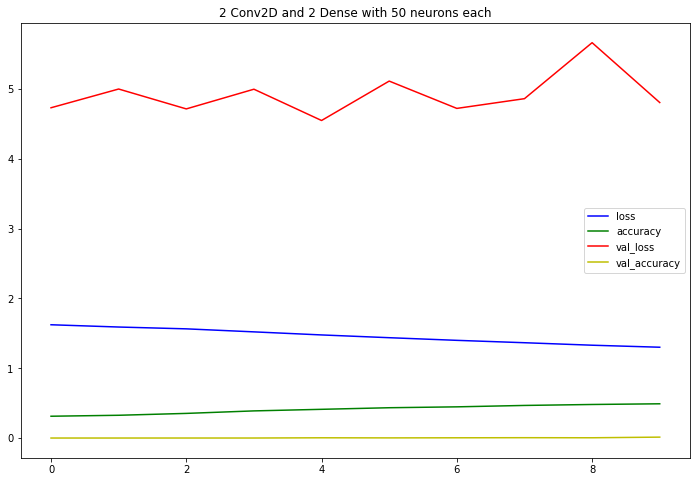

In [143]:
plot_training_history(history, '2 Conv2D + 2 Hidden Dense with 50 Neurons')

In [162]:
from tensorflow.keras.applications import Xception

resized_dim = (IMG_DIM[0] * 2, IMG_DIM[1] * 2)

def build_xception_model(n_dense_layers=2, n_neurons=50):

    xception = Xception(include_top=False, input_shape=resized_dim + (3,), classes=N_CLASSES)
    xception.trainable = False

    model = models.Sequential([
        layers.InputLayer(input_shape=IMG_DIM + (3,)),
        layers.Resizing(resized_dim[0], resized_dim[1]),
        layers.Rescaling(1./255),
        xception,
        layers.Flatten()])
    
    for _ in range(n_dense_layers):
        model.add(layers.Dense(n_neurons, activation='relu'))

    layers.Dense(N_CLASSES, activation='softmax')
    
    model.compile(
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
    optimizer='adam')

    return model

In [163]:
xception_model = build_xception_model(2, 50)
xception_model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_2 (Resizing)       (None, 96, 96, 3)         0         
                                                                 
 rescaling_19 (Rescaling)    (None, 96, 96, 3)         0         
                                                                 
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 flatten_23 (Flatten)        (None, 18432)             0         
                                                                 
 dense_60 (Dense)            (None, 50)                921650    
                                                                 
 dense_61 (Dense)            (None, 50)                2550      
                                                                 
Total params: 21,785,680
Trainable params: 924,200
No

In [164]:
history = xception_model.fit(trainX, trainy, epochs=50, validation_split=.2, batch_size=32, callbacks=make_callbacks())

Epoch 1/50
718/718 [==============================] - 30s 39ms/step - loss: 8.7779 - accuracy: 0.1736 - val_loss: 18.1972 - val_accuracy: 0.0000e+00
Epoch 2/50
718/718 [==============================] - 27s 38ms/step - loss: 8.5009 - accuracy: 0.1778 - val_loss: 17.4639 - val_accuracy: 0.0000e+00
Epoch 3/50
718/718 [==============================] - 27s 38ms/step - loss: 8.4401 - accuracy: 0.2167 - val_loss: 17.5043 - val_accuracy: 0.0000e+00
Epoch 4/50
718/718 [==============================] - 27s 38ms/step - loss: 8.3408 - accuracy: 0.2187 - val_loss: 17.5043 - val_accuracy: 0.0000e+00
Epoch 5/50
718/718 [==============================] - 28s 39ms/step - loss: 8.3408 - accuracy: 0.2187 - val_loss: 17.5043 - val_accuracy: 0.0000e+00
Epoch 6/50
718/718 [==============================] - 28s 38ms/step - loss: 8.3408 - accuracy: 0.2186 - val_loss: 17.5043 - val_accuracy: 0.0000e+00
Epoch 7/50
718/718 [==============================] - 28s 39ms/step - loss: 8.3407 - accuracy: 0.2186 - va

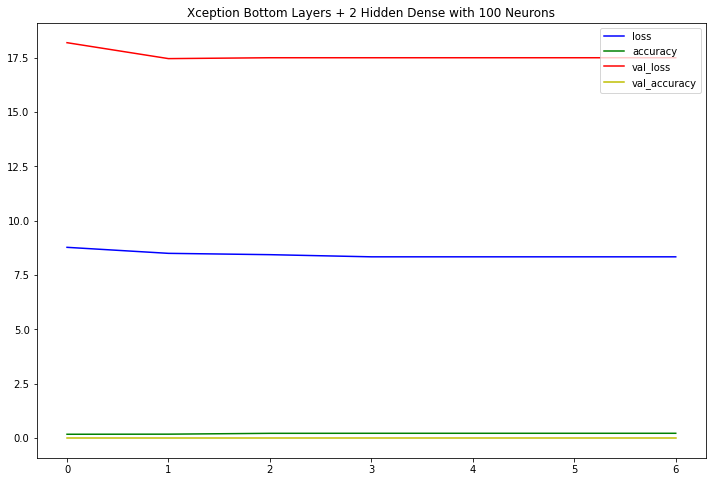

In [165]:
plot_training_history(history, 'Xception Bottom Layers + 2 Hidden Dense with 100 Neurons')

In [167]:
conv2d_model.evaluate(testX, testy), xception_model.evaluate(testX, testy)

(80, 4096)